In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [2]:
import pyspark.sql.functions as F

In [3]:
lending = spark.read.csv('accepted_2007_to_2018Q4.csv.gz', inferSchema=True, header=True)
lending.printSchema()

root
 |-- id: string (nullable = true)
 |-- member_id: string (nullable = true)
 |-- loan_amnt: double (nullable = true)
 |-- funded_amnt: double (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_title: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: string (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- pymnt_plan: string (nullable = true)
 |-- url: string (nullable = true)
 |-- desc: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- title: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: string 

# Cleaning and Tranforming Data

## Decide on categories for features


In [4]:
lending.select('loan_status').distinct().show(20, False) #shows different loan statuses
#modified to show full status.

+---------------------------------------------------+
|loan_status                                        |
+---------------------------------------------------+
|Fully Paid                                         |
|Default                                            |
|null                                               |
|In Grace Period                                    |
|Does not meet the credit policy. Status:Fully Paid |
|Charged Off                                        |
|Oct-2015                                           |
|Late (31-120 days)                                 |
|Current                                            |
|Does not meet the credit policy. Status:Charged Off|
|Late (16-30 days)                                  |
+---------------------------------------------------+



Response variable is loan_status. Here we look at stats and change the loan status column so that "Default", "Charged Off", and "Does not meet the credit policy. Status:Charged Off" are all 1 (for default) and everything else is 0.

In [5]:
# Show counts of each loan status.. and percentage

lending_status = lending.select('loan_status')
total_rec = lending.count()
lending_stat_grp = lending_status.groupBy('loan_status').count()
lending_stat_grp = lending_stat_grp.withColumn('percentage', lending_stat_grp['count']/total_rec * 100)
#c = 'percentage'
lending_stat_grp.show(20,False) # I need to round this column but haven't figured that out yet also the 20



+---------------------------------------------------+------+---------------------+
|loan_status                                        |count |percentage           |
+---------------------------------------------------+------+---------------------+
|Fully Paid                                         |984836|49.450853483099806   |
|Default                                            |27    |0.0013557313543003044|
|null                                               |27    |0.0013557313543003044|
|In Grace Period                                    |6916  |0.3472680757904039   |
|Does not meet the credit policy. Status:Fully Paid |1988  |0.09982199749440761  |
|Charged Off                                        |239904|12.04612499340964    |
|Oct-2015                                           |1     |5.021227238149276E-5 |
|Late (31-120 days)                                 |17134 |0.860337074984497    |
|Current                                            |736467|36.97968160398083    |
|Doe

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

In [7]:
statuses = lending_stat_grp.select("loan_status").rdd.flatMap(lambda x: x).collect()
statuses[2]="None" # since Plotting doesn't like None
status_counts =  lending_stat_grp.select("count").rdd.flatMap(lambda x: x).collect()

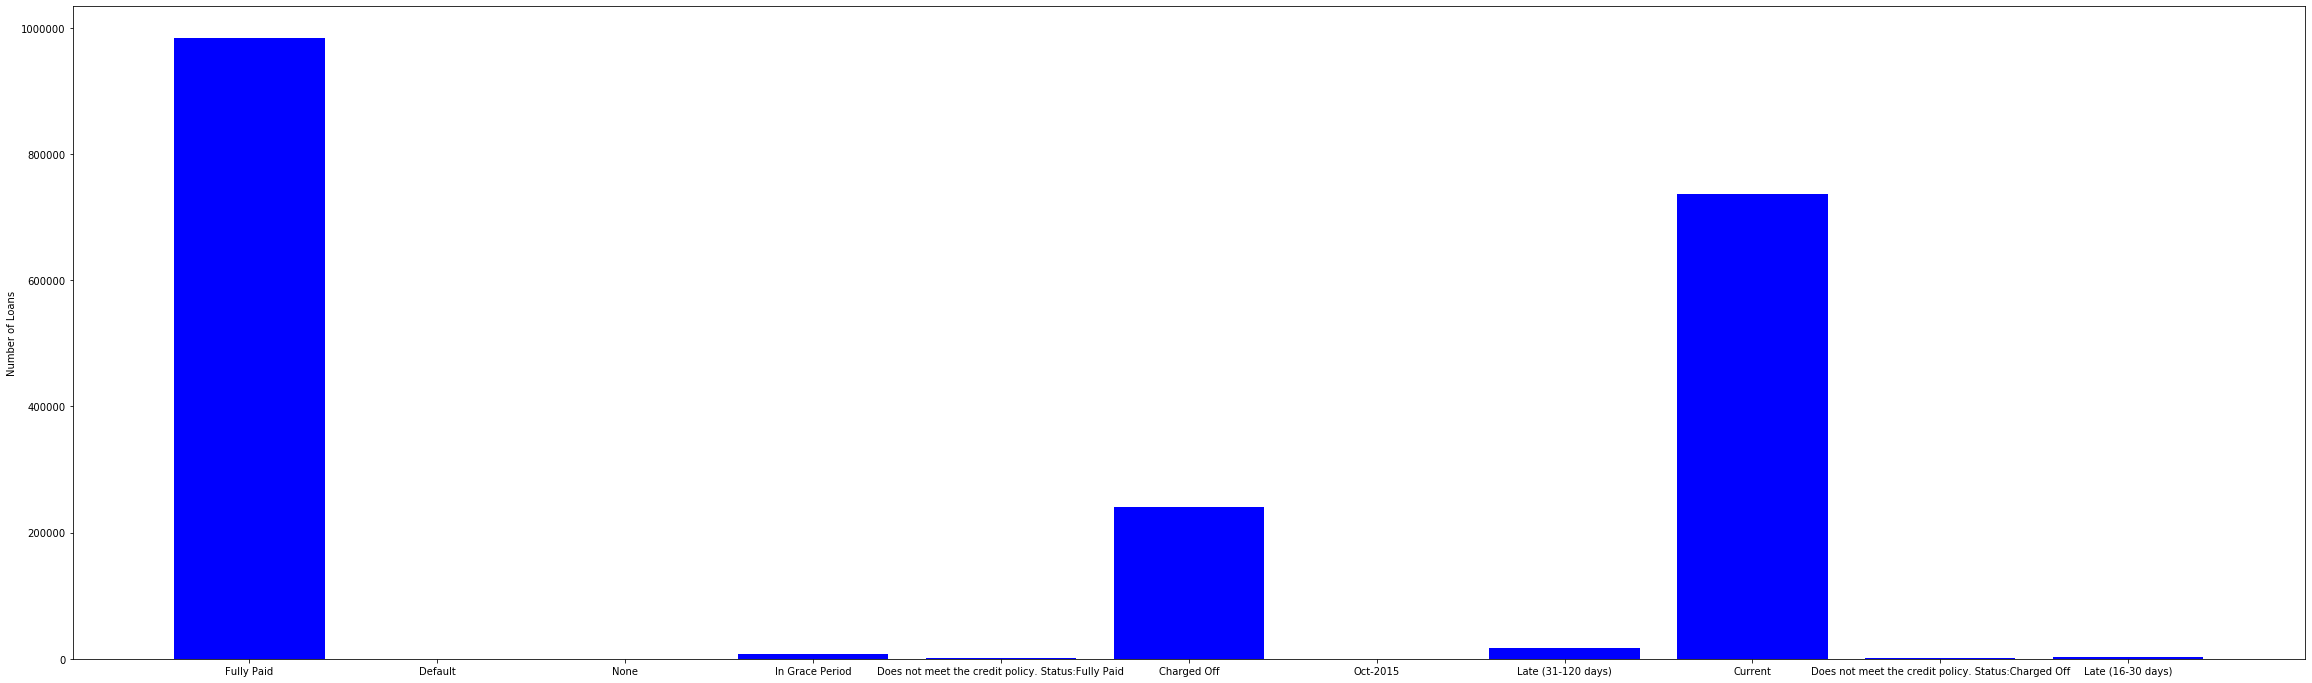

In [8]:
# Plotting Response Variable
plt.figure(figsize=(40,12))
plt.bar(statuses, status_counts, width=0.8, label='Loan Status', color='blue')
#plt.xticks(ind, labels)
plt.ylabel("Number of Loans")
plt.show()
#we can see the majority of our data set is current and fully paid. With Charged off being the 3rd largest

In [4]:
#making loan status binary 1: Default 0: Current
lending = lending.withColumn('loan_status_binary', F.when( (lending['loan_status'] == 'Default') | \
                                            (lending['loan_status'] == 'Charged Off') | \
                                            (lending['loan_status'] == 'Charged off and Does not meet the credit policy.'),1).otherwise(0))


In [10]:
lending.groupBy('loan_status_binary').count().show()

+------------------+-------+
|loan_status_binary|  count|
+------------------+-------+
|                 1| 239931|
|                 0|1751614|
+------------------+-------+



In [26]:
df = lending.select('loan_status_binary','loan_amnt', 'term', 'int_rate', 'grade', 'emp_length',
                          'home_ownership', 'tot_cur_bal', 'total_pymnt', 'annual_inc', 'addr_state', 
                             'fico_range_low', 'last_pymnt_amnt')

In [6]:
df.printSchema()

root
 |-- loan_status_binary: integer (nullable = false)
 |-- loan_amnt: double (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- tot_cur_bal: string (nullable = true)
 |-- total_pymnt: string (nullable = true)
 |-- annual_inc: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- fico_range_low: string (nullable = true)
 |-- last_pymnt_amnt: string (nullable = true)



In [13]:
# for each field, compute missing percentage

df.agg(*[
    (1 - F.count(c) / F.count('*')).alias(c + '_miss')
    for c in df.columns
]).show()

+-----------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|loan_status_binary_miss|      loan_amnt_miss|           term_miss|       int_rate_miss|          grade_miss|    emp_length_miss| home_ownership_miss|   tot_cur_bal_miss|    total_pymnt_miss|     annual_inc_miss|     addr_state_miss| fico_range_low_miss|last_pymnt_amnt_miss|
+-----------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                    0.0|1.355731354302225...|1.355731354302225...|1.355731354302225...|1.355731354302225...|0.06404776191348927|1.355731354302225...|0.03524801096636032|2.

In [14]:
df.take(3)

[Row(loan_status_binary=0, loan_amnt=3600.0, term=' 36 months', int_rate=13.99, grade='C', emp_length='10+ years', home_ownership='MORTGAGE', tot_cur_bal='144904.0', total_pymnt='4421.723916800001', annual_inc='55000.0', addr_state='PA', fico_range_low='675.0', last_pymnt_amnt='122.67'),
 Row(loan_status_binary=0, loan_amnt=24700.0, term=' 36 months', int_rate=11.99, grade='C', emp_length='10+ years', home_ownership='MORTGAGE', tot_cur_bal='204396.0', total_pymnt='25679.66', annual_inc='65000.0', addr_state='SD', fico_range_low='715.0', last_pymnt_amnt='926.35'),
 Row(loan_status_binary=0, loan_amnt=20000.0, term=' 60 months', int_rate=10.78, grade='B', emp_length='10+ years', home_ownership='MORTGAGE', tot_cur_bal='189699.0', total_pymnt='22705.924293878397', annual_inc='63000.0', addr_state='IL', fico_range_low='695.0', last_pymnt_amnt='15813.3')]

In [15]:
df.cache()

DataFrame[loan_status_binary: int, loan_amnt: double, term: string, int_rate: double, grade: string, emp_length: string, home_ownership: string, tot_cur_bal: string, total_pymnt: string, annual_inc: string, addr_state: string, fico_range_low: string, last_pymnt_amnt: string]

In [7]:
#Find different term levels
df.select('term').distinct().show()

+----------+
|      term|
+----------+
| 36 months|
|      null|
| 60 months|
+----------+



In [11]:
#Count different levels of term
df.groupBy('term').count().show()

+----------+-------+
|      term|  count|
+----------+-------+
| 36 months|1609754|
|      null|     33|
| 60 months| 650914|
+----------+-------+



In [27]:
#remove null rows
df = df.filter(df.term.isNotNull())

In [13]:
# row count
print(f'rows={df.count()}')

rows=2260668


In [14]:
# distinct row count
print(f'rows={df.distinct().count()}')

rows=2260668


In [15]:
#Looks like there are duplicates so we will drop those
df = df.dropDuplicates()
print(f'rows={df.count()}')

rows=2260668


### Analyze Annual Income

In [28]:
#See if any rows of annual income contain non-numeric values
df.select('annual_inc').filter(df['annual_inc'].rlike('[A-Za-z]+')).show()

+----------+
|annual_inc|
+----------+
|  MORTGAGE|
+----------+



In [29]:
#Remove string row and convert column to float
df = df.filter(df['annual_inc'] != 'MORTGAGE')
df = df.withColumn('annual_inc', df['annual_inc'].cast('float'))

### Clean Up Other Columns

In [30]:
#Convert these columns since they are numbers but cast as strings in original data
df = df.withColumn("tot_cur_bal", df['tot_cur_bal'].cast('float'))
df = df.withColumn("total_pymnt", df["total_pymnt"].cast('float'))
df = df.withColumn("fico_range_low", df["fico_range_low"].cast('float'))
df = df.withColumn("last_pymnt_amnt", df["last_pymnt_amnt"].cast('float'))

In [31]:
#Descriptive stats on numerical columns
df.describe('loan_amnt', 'int_rate', 'tot_cur_bal', 'total_pymnt','last_pymnt_amnt',
           'annual_inc').show()

+-------+------------------+------------------+------------------+-----------------+------------------+------------------+
|summary|         loan_amnt|          int_rate|       tot_cur_bal|      total_pymnt|   last_pymnt_amnt|        annual_inc|
+-------+------------------+------------------+------------------+-----------------+------------------+------------------+
|  count|           2260663|           2260663|           2190483|          2260602|           2260596|           2260663|
|   mean|15046.948715929795|13.092839361552358| 142486.1040603191|12081.56774035071|3429.3736329090775| 77992.44637777765|
| stddev| 9190.247731503456|  4.83213840831225|160691.96771854538|9901.817686563325| 6018.386982155856|112696.22136098483|
|    min|             500.0|              5.31|               0.0|              0.0|               0.0|               0.0|
|    max|           40000.0|             30.99|         9971659.0|         63296.88|          42192.05|             1.1E8|
+-------+-------

In [23]:
df.groupBy('addr_state').count().orderBy('count', ascending=False).show(66)

+--------------------+------+
|          addr_state| count|
+--------------------+------+
|                  CA|278282|
|                  NY|164364|
|                  TX|163578|
|                  FL|141821|
|                  IL| 80035|
|                  NJ| 73359|
|                  PA| 67702|
|                  OH| 66239|
|                  GA| 65303|
|                  VA| 55972|
|                  NC| 55351|
|                  MI| 51606|
|                  MD| 47546|
|                  AZ| 47126|
|                  MA| 45731|
|                  CO| 42408|
|                  WA| 41953|
|                  MN| 34783|
|                  IN| 32785|
|                  MO| 31725|
|                  CT| 31411|
|                  TN| 31116|
|                  NV| 28735|
|                  WI| 26300|
|                  SC| 24651|
|                  AL| 24066|
|                  OR| 23871|
|                  LA| 22719|
|                  KY| 19267|
|                  OK| 18267|
|         

It looks like there are some rows that aren't actually states, we'll need to get rid of those

In [24]:
#This uses a regex to find only state names on the 'addr_state' column
df= df.filter(df['addr_state'].rlike("^[A-Z]{2}$"))
#we can check that those rows have been removed
df.count()


1991262

In [25]:
df.groupBy('addr_state').count().orderBy('count', ascending=False).show(66)

+----------+------+
|addr_state| count|
+----------+------+
|        CA|278282|
|        NY|164364|
|        TX|163578|
|        FL|141821|
|        IL| 80035|
|        NJ| 73359|
|        PA| 67702|
|        OH| 66239|
|        GA| 65303|
|        VA| 55972|
|        NC| 55351|
|        MI| 51606|
|        MD| 47546|
|        AZ| 47126|
|        MA| 45731|
|        CO| 42408|
|        WA| 41953|
|        MN| 34783|
|        IN| 32785|
|        MO| 31725|
|        CT| 31411|
|        TN| 31116|
|        NV| 28735|
|        WI| 26300|
|        SC| 24651|
|        AL| 24066|
|        OR| 23871|
|        LA| 22719|
|        KY| 19267|
|        OK| 18267|
|        KS| 16893|
|        AR| 15017|
|        UT| 13211|
|        MS| 10863|
|        NM| 10643|
|        NH|  9852|
|        HI|  9443|
|        RI|  8833|
|        WV|  7976|
|        NE|  6515|
|        DE|  5668|
|        MT|  5574|
|        DC|  4759|
|        AK|  4691|
|        VT|  4347|
|        WY|  4213|
|        ME|  4148|


In [26]:
#Find Outliers

bnds = {}
cols = ['loan_amnt', 'int_rate', 'tot_cur_bal', 'fico_range_low']

def outliers(df):

    for col in cols:
        quantiles = df.approxQuantile(col, [0.25, 0.75], 0.05)
        IQR = quantiles[1] - quantiles[0]

        bnds[col] = [
         quantiles[0] - 1.5 * IQR,
         quantiles[1] + 1.5 * IQR
        ]
    return bnds

In [27]:
#Show Quantiles
outliers(df.select(cols))

{'loan_amnt': [-14000.0, 50000.0],
 'int_rate': [5.320000000000001, 24.439999999999998],
 'tot_cur_bal': [-260895.0, 539905.0],
 'fico_range_low': [620.0, 780.0]}

We'll have to look into these negative numbers and clean them up, nobody actually got a negative balance

## Examine Grade

In [28]:
df.groupBy('grade').count().orderBy('count').show()

+-----+------+
|grade| count|
+-----+------+
|    G| 10962|
|    F| 38059|
|    E|123186|
|    D|284164|
|    A|389567|
|    C|567448|
|    B|577876|
+-----+------+



In [29]:
#remove null rows
df = df.filter(df.grade.isNotNull())

In [30]:
#Create dummy columns
grade_AB = F.when(
    F.col("grade") == 'A', 1
).when(F.col("grade") == 'B', 1).otherwise(0)

grade_CD = F.when(
    F.col("grade") == 'C', 1
).when(F.col("grade") == 'D', 1).otherwise(0)

grade_EFG = F.when(
    F.col("grade") == 'E', 1
).when(F.col("grade") == 'F', 1
).when(F.col("grade") == 'G', 1).otherwise(0)

In [31]:
#add new columns to train data
df = df.withColumn('grade_AB', grade_AB)
df = df.withColumn('grade_CD', grade_CD)
df = df.withColumn('grade_EFG', grade_EFG)

In [32]:
#remove redundant grade column
df = df.drop('grade')

df.show(10)

+------------------+---------+----------+--------+----------+--------------+-----------+-----------+----------+----------+--------------+---------------+--------+--------+---------+
|loan_status_binary|loan_amnt|      term|int_rate|emp_length|home_ownership|tot_cur_bal|total_pymnt|annual_inc|addr_state|fico_range_low|last_pymnt_amnt|grade_AB|grade_CD|grade_EFG|
+------------------+---------+----------+--------+----------+--------------+-----------+-----------+----------+----------+--------------+---------------+--------+--------+---------+
|                 0|  11000.0| 36 months|    7.21|      null|           ANY|    28511.0|    1354.03|   40000.0|        PA|         715.0|         340.71|       1|       0|        0|
|                 0|   4000.0| 36 months|    22.9|      null|           ANY|   108997.0|    1386.67|   40000.0|        MI|         665.0|         154.64|       0|       0|        1|
|                 0|  10000.0| 36 months|   17.97|  < 1 year|           ANY|    20320.0|  

## Examine emp_length

In [33]:
df.groupBy('emp_length').count().orderBy('count').show()

+----------+------+
|emp_length| count|
+----------+------+
|   9 years| 70020|
|   8 years| 82747|
|   7 years| 83447|
|   6 years| 90656|
|   4 years|120224|
|   5 years|123451|
|      null|127524|
|    1 year|130781|
|   3 years|159495|
|  < 1 year|165980|
|   2 years|179101|
| 10+ years|657836|
+----------+------+



In [34]:
#Create dummy columns

emp_length_low = F.when(
    F.col("emp_length") == '< 1 year', 1
).when(F.col("emp_length") == '2 years', 1
).when(F.col("emp_length") == '3 years', 1
).when(F.col("emp_length") == '4 years', 1
).when(F.col("emp_length") == '5 years', 1).otherwise(0)

emp_length_high = F.when(
    F.col("emp_length") == '6 years', 1
).when(F.col("emp_length") == '7 years', 1
).when(F.col("emp_length") == '8 years', 1
).when(F.col("emp_length") == '9 years', 1
).when(F.col("emp_length") == '10+ years', 1).otherwise(0)

In [35]:
#add dummy columns to train data
df = df.withColumn('emp_length_low', emp_length_low)
df = df.withColumn('emp_length_high', emp_length_high)

#Remove redundant "emp_length" column
df = df.drop('emp_length')
df.show(10)

+------------------+---------+----------+--------+--------------+-----------+-----------+----------+----------+--------------+---------------+--------+--------+---------+--------------+---------------+
|loan_status_binary|loan_amnt|      term|int_rate|home_ownership|tot_cur_bal|total_pymnt|annual_inc|addr_state|fico_range_low|last_pymnt_amnt|grade_AB|grade_CD|grade_EFG|emp_length_low|emp_length_high|
+------------------+---------+----------+--------+--------------+-----------+-----------+----------+----------+--------------+---------------+--------+--------+---------+--------------+---------------+
|                 0|  11000.0| 36 months|    7.21|           ANY|    28511.0|    1354.03|   40000.0|        PA|         715.0|         340.71|       1|       0|        0|             0|              0|
|                 0|   4000.0| 36 months|    22.9|           ANY|   108997.0|    1386.67|   40000.0|        MI|         665.0|         154.64|       0|       0|        1|             0|       

In [36]:
#Removing a dummy variable column for "grade" and "emp_length", since number of columns should be n-1, where n is number of categories
df = df.drop('grade_AB')
df = df.drop('emp_length_high')
df.printSchema()

root
 |-- loan_status_binary: integer (nullable = false)
 |-- loan_amnt: double (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- tot_cur_bal: float (nullable = true)
 |-- total_pymnt: float (nullable = true)
 |-- annual_inc: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- fico_range_low: float (nullable = true)
 |-- last_pymnt_amnt: float (nullable = true)
 |-- grade_CD: integer (nullable = false)
 |-- grade_EFG: integer (nullable = false)
 |-- emp_length_low: integer (nullable = false)

